# Evaluation of performance of Coulomb force evaluation

In this notebook we have a quick look at the performance of the Coulomb force evalution and our optimizations. The timing results in this notebook were obtained on a low end AMD A6 laptop CPU.

In [3]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import time

We evaluate the performance by doing a few force evalutations and measuring the elapsed time:

In [4]:
def measure_time(num_ptcls, per_ptcl_charges=False, num_iter=1, use_reference_impl=False):
    ensemble = coldatoms.Ensemble(num_ptcls=num_ptcls)
    ensemble.x = np.random.random([num_ptcls, 3])
    if per_ptcl_charges:
        ensemble.set_particle_properties('charge', np.random.random(num_ptcls))
    else:
        ensemble.ensemble_properties['charge'] = 1.0
    
    f = coldatoms.CoulombForce()
    if use_reference_impl:
        f.use_reference_implementations()
    
    accumulated_force = np.zeros_like(ensemble.v)
    
    t0 = time.time()
    for i in range(num_iter):
        f.force(1.0e-1, ensemble, accumulated_force)
    t1 = time.time()
    return t1 - t0

We consider particle numbers on a logarithmic scale:

In [5]:
def num_ptcls(n_min, n_max, n):
    return [n_min * (n_max / n_min)**(i/(n - 1)) for i in range(n)]

Here is the performance of the naive C implementation (for comparison we also show the performance obtained on a AWS EC2 C4 instance).

<IPython.core.display.Javascript object>


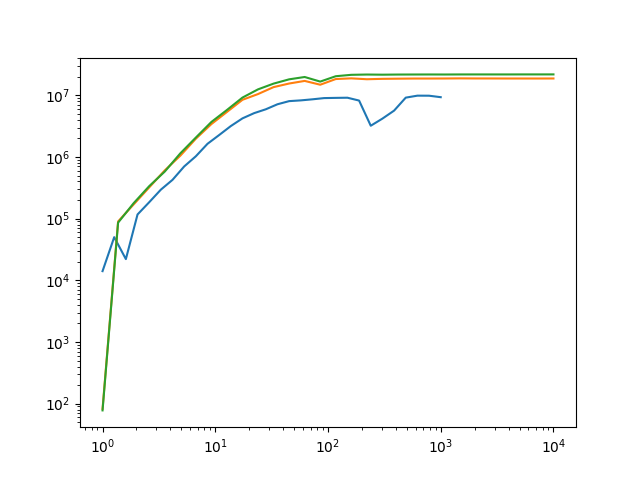

In [9]:
nptcls = np.array(num_ptcls(1, 1000, 30))
times = np.array([measure_time(int(round(n)), num_iter=5) for n in nptcls])
pairs_per_second = nptcls**2 / times
c4_nptcls = np.array([  1.00000000e+00,   1.37382380e+00,   1.88739182e+00,   2.59294380e+00,
   3.56224789e+00,   4.89390092e+00,   6.72335754e+00,   9.23670857e+00,
   1.26896100e+01,   1.74332882e+01,   2.39502662e+01,   3.29034456e+01,
   4.52035366e+01,   6.21016942e+01,   8.53167852e+01,   1.17210230e+02,
   1.61026203e+02,   2.21221629e+02,   3.03919538e+02,   4.17531894e+02,
   5.73615251e+02,   7.88046282e+02,   1.08263673e+03,   1.48735211e+03,
   2.04335972e+03,   2.80721620e+03,   3.85662042e+03,   5.29831691e+03,
   7.27895384e+03,   1.00000000e+04])
c4_pairs_per_second = np.array([  8.21896849e+01,   8.99578985e+04,   1.69785802e+05,   3.20452334e+05,
   6.04819115e+05,   1.04640310e+06,   1.97497265e+06,   3.40804318e+06,
   5.36026069e+06,   8.44192672e+06,   1.04605076e+07,   1.35549480e+07,
   1.54981408e+07,   1.70811388e+07,   1.48204588e+07,   1.83218908e+07,
   1.87899007e+07,   1.81859734e+07,   1.84545152e+07,   1.85655733e+07,
   1.86642306e+07,   1.86659059e+07,   1.87018426e+07,   1.87843680e+07,
   1.87249206e+07,   1.87188841e+07,   1.86915702e+07,   1.86896431e+07,
   1.86820557e+07,   1.87087450e+07])
c4_pairs_per_second_opt = np.array([  7.77428407e+01,   8.60466855e+04,   1.77870840e+05,   3.35711969e+05,
   5.78522632e+05,   1.14153065e+06,   2.06084102e+06,   3.68911890e+06,
   5.77258843e+06,   9.17072615e+06,   1.24658899e+07,   1.54452639e+07,
   1.81193908e+07,   1.97748636e+07,   1.66558348e+07,   2.03540609e+07,
   2.14466467e+07,   2.16752990e+07,   2.15554241e+07,   2.16672624e+07,
   2.17012696e+07,   2.17274807e+07,   2.16995063e+07,   2.17516952e+07,
   2.17600542e+07,   2.17549355e+07,   2.17497805e+07,   2.17769467e+07,
   2.17739088e+07,   2.17851869e+07])
plt.figure()
plt.loglog(nptcls, pairs_per_second);
plt.loglog(c4_nptcls, c4_pairs_per_second);
plt.loglog(c4_nptcls, c4_pairs_per_second_opt);

The latency can be inferred from the time it takes to deal with just one pair:

In [7]:
times[0]

9.441375732421875e-05

In the limit of large numbers of particles we process on the order of $6\times 10^6$ particle pairs per second:

In [8]:
pairs_per_second[-1]

8518601.8644515295

For the numbers of particles considered here we do not observe any cache effects yet. This could be due to inefficiencies in the force evaluation function or due to the relatively small number of particles (Easily fits in L2, almost fits into L1 cache). We can model the processing speed using latency and the processing speed at large numbers of particles.

In [9]:
def const_rate_model(latency, rate, num_ptcls):
    num_pairs = num_ptcls**2
    total_time = latency + num_pairs / rate
    return num_pairs / total_time

<IPython.core.display.Javascript object>


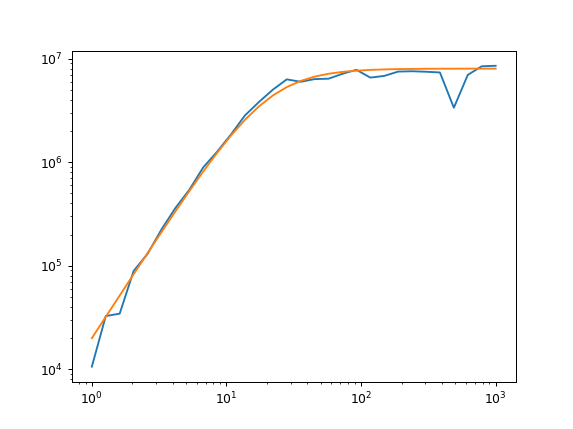

In [15]:
plt.figure()
plt.loglog(nptcls, pairs_per_second)
plt.loglog(nptcls, [const_rate_model(5.0e-5, 8.0e6, n) for n in nptcls]);

# Comparison of different implementations

In the following we compare a few different implementations.

## Timing data

Some of the timing data required recompilation of the coldatoms c-extension and thus restarting of the python kernel. We therefore inline the timing data here. For all timing data we use the following numbers of particles:

In [16]:
nptcls = np.array([    1.        ,     1.268961  ,     1.61026203,     2.04335972,
           2.5929438 ,     3.29034456,     4.17531894,     5.29831691,
           6.72335754,     8.53167852,    10.82636734,    13.73823796,
          17.43328822,    22.12216291,    28.07216204,    35.6224789 ,
          45.20353656,    57.3615251 ,    72.78953844,    92.36708572,
         117.21022975,   148.73521073,   188.73918221,   239.502662  ,
         303.91953823,   385.66204212,   489.39009185,   621.01694189,
         788.04628157,  1000.        ])

The reference implementation has this performance:

In [17]:
pairs_per_second_reference = np.array([  3754.97224709,  10422.72910995,   6161.80993837,  10058.90690229,
         7977.31411846,  12252.85370598,   7772.16310828,  10301.24072883,
         8244.43945831,   9103.42166074,   9766.48063046,   9611.93684861,
        10848.58925705,  10003.22038508,  10536.11487913,  10502.85977021,
        13790.40041135,  14756.04096312,  13686.40446465,  14516.38360699,
        13543.29197737,  13759.00597281,  13842.27083136,  13488.36978563,
        12883.47362135,  12343.43336072,  11535.69300621,  11728.47328488,
        11188.22477577,   8771.32862753])

Here is the performance of a direct translation of the reference implementation to C:

In [18]:
pairs_per_second_naive_c = np.array([   10699.75510204,    30839.85584258,    55206.0638283 ,
          90738.63706541,   136230.94427643,   221507.68668544,
         363783.63504059,   580015.67337796,   857906.67158507,
        1327397.61712042,  1862179.30155215,  2692617.37091628,
        3417509.20801424,  3759433.7356532 ,  5912890.28819334,
        6210511.33097665,  6165807.07674836,  6578029.24543723,
        6245854.91663751,  7587882.39220302,  7396963.5969694 ,
        7803134.84028501,  8355880.86492011,  8627377.42296997,
        8725380.89446372,  8792556.68439878,  8841519.959524  ,
        8266728.56837714,  6405629.27527453,  7742010.74647583])

Here is a C implementation with where the outer and inner particle loops in the pairwise force are chunked to enable vectorizatio and caching. This version was compiled with -msse4 and thus uses SSE4 vectorization. This is currently the default implementation used in the coldatoms library.

In [19]:
pairs_per_second_chunked = np.array([  4.40592035e+01,   3.26276736e+04,   5.57722799e+04,
         8.88962282e+04,   1.41707565e+05,   2.25915800e+05,
         3.63783635e+05,   5.63364506e+05,   8.46416850e+05,
         1.31595453e+06,   1.99843632e+06,   2.58702453e+06,
         3.70561318e+06,   4.41430284e+06,   5.56448766e+06,
         4.47261194e+06,   6.02281928e+06,   6.84558797e+06,
         6.13549194e+06,   6.95519016e+06,   6.78948349e+06,
         6.53108161e+06,   6.84557435e+06,   6.45104368e+06,
         6.50288098e+06,   6.45530515e+06,   5.69232280e+06,
         4.99511738e+06,   7.79344758e+06,   7.58281281e+06])

The following version was compiled with -mavx. On the laptop used for these timing studies this is the most advanced vector instruction set.

In [20]:
pairs_per_second_chunked_avx = np.array([   12409.18343195,    37943.4181434 ,    62146.25470958,
         100071.75402071,   168861.11057018,   267112.2104148 ,
         395246.00347654,   684553.38195189,  1030420.5131538 ,
        1503948.03910195,  2204553.07448326,  3166518.02819754,
        4652302.68098289,  5654685.45362713,  7002766.25233067,
        6867623.49760902,  8232922.03331433,  9133491.30173879,
        8718223.53605189,  8283438.27815497,  7369528.89377051,
        7376934.04244149,  8322369.84045209,  7516375.83786946,
        7549459.96638704,  7623711.51199181,  7380784.94405883,
        6349442.00772738,  6432029.20628165,  8554706.17509566])

The following implementation uses OpenMP to parallelize the outer loop over particles. The laptop used for these timing studies has 2 cores. Therfore only a modest acceleration was achieved. For large numbers of particles we expect a nearly ideal speedup of 2x.

In [35]:
pairs_per_second_chunked_avx_openmp = np.array([  1.43566798e+02,   1.78481764e+02,   3.11719871e+02,
         4.78615932e+02,   7.87616061e+02,   1.12574251e+03,
         1.99908441e+03,   3.10250538e+03,   5.52021704e+03,
         5.58577039e+03,   1.43348983e+04,   2.15350791e+04,
         3.36393871e+04,   2.45797009e+04,   5.68420037e+04,
         5.04015929e+06,   7.26927213e+06,   8.20006260e+06,
         9.90760223e+06,   9.57827981e+06,   8.98103903e+06,
         1.04068053e+07,   1.03363200e+07,   3.15302633e+06,
         2.49586490e+06,   7.32430894e+06,   6.46459903e+06,
         7.77060651e+06,   1.17015150e+07,   1.19050503e+07])

## Visualization of the timing data

The following plot shows the performance of the different implementations

<IPython.core.display.Javascript object>


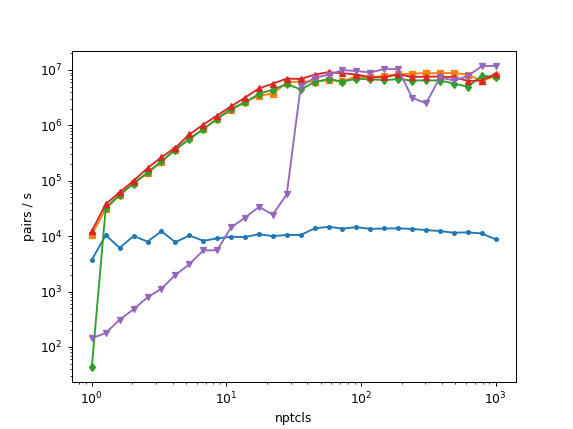

In [34]:
plt.figure()
plt.loglog(nptcls, pairs_per_second_reference, '.-')
plt.loglog(nptcls, pairs_per_second_naive_c, 's-', ms=5)
plt.loglog(nptcls, pairs_per_second_chunked, 'd-', ms=5)
plt.loglog(nptcls, pairs_per_second_chunked_avx, '^-', ms=5)
plt.loglog(nptcls, pairs_per_second_chunked_avx_openmp, 'v-', ms=5)
plt.xlabel('nptcls')
plt.ylabel('pairs / s');

## Observations

Here are some observations about the relative and absolute performance of the different implementations:

- The C implementations are significantly faster than the reference implementation in python. For 100 particles and more the performance advantage is 2 to 3 orders of magnitude. For small numbers of particles there is no additional latency penalty to be paid for calling out to the C extension. Rather the C implementation is always faster than the Python implementation.
- The different vector instruction sets lead to only rather minor differences. For the most part the performance differences are buried in the noise.
- We experimented with different chunk sizes. For chunk sizes of 32 and larger we obtained consistent vectorization with both clang and recent versions of gcc. We therefore use this chunk size.
- The relatively large chunk size leads to some noise in the timing data because the amount of cleanup required varies drastically depending on the actual number of particles.
- OpenMP threading causes a large latency of about 10ms. This overhead can only be ammortized for relatively large numbers of particles. However for very large numbers of particles we expect a nearly ideal speedup.
- When the force evaluation routine is called for the first time we notice a relatively large latency (e.g. visible for the green diamond dataset in the plot above). We suspect that this is caused by the lazy loading of the shared library for the extension.